<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print("Unique words in Corpus: ",data['Word'].nunique())
#same as  data["Tag"]

Unique words in Corpus:  35178


In [5]:
words=list(set(data["Word"].values))
words.append("ENDPAD")
num_words=len(words)
print(num_words)

35179


In [40]:
tags=list(set(data["Tag"].values))
num_tags=len(tags)
print(num_tags)

17


### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent=1
        self.data=data
        agg_func=lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                    s["POS"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_func)
        self.sentences=[s for s in self.grouped]

In [8]:
getter=SentenceGetter(data)
sentences=getter.sentences

In [48]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [49]:
wrd2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [50]:
tag2idx

{'B-per': 0,
 'I-per': 1,
 'B-eve': 2,
 'I-tim': 3,
 'I-gpe': 4,
 'B-tim': 5,
 'I-geo': 6,
 'B-nat': 7,
 'I-org': 8,
 'I-eve': 9,
 'O': 10,
 'B-geo': 11,
 'B-art': 12,
 'I-nat': 13,
 'B-gpe': 14,
 'I-art': 15,
 'B-org': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

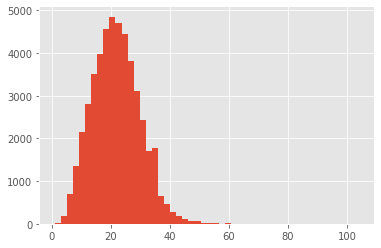

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[wrd2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])
z=[]
for i in y:
    #print(i)
    z.append(to_categorical(i, num_tags))
    #print(to_categorical(i, 17+1))
#y = [to_categorical(i, num_tags) for i in y]
#y=to_categorical([11,11,15, 15, 14, 13],17)
#print(y)
y=z

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [54]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [55]:
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model=Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Task 7: Train the Model

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [58]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks= [PlotLossesCallback(), early_stopping]

h=model.fit(x_train, np.array(y_train),
           validation_split=0.2,
           batch_size=32,
           epochs=3,
           verbose=1)

Train on 34530 samples, validate on 8633 samples
Epoch 1/3
34530/34530 [==============================] - 196s 6ms/sample - loss: 0.1908 - accuracy: 0.9562 - val_loss: 0.0700 - val_accuracy: 0.9799
Epoch 2/3
34530/34530 [==============================] - 181s 5ms/sample - loss: 0.0544 - accuracy: 0.9840 - val_loss: 0.0502 - val_accuracy: 0.9847
Epoch 3/3
34530/34530 [==============================] - 187s 5ms/sample - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.0483 - val_accuracy: 0.9850


### Task 8: Evaluate Named Entity Recognition Model

In [61]:
model.evaluate(x_test,np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0495 - accuracy: 0.9850


[0.04954904121493577, 0.98499584]

In [64]:
i= np.random.randint(0, x_test.shape[0])
p=model.predict(np.array([x_test[i]]))
p=np.argmax(p, axis=-1)

y_true=np.argmax(np.array(y_test), axis=-1)[i]
print("{:15} {:5}\t {}".format("Word", "True", "pred"))
print("-"*30)
for w, true, pred in zip (x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word            True 	 pred
------------------------------
The            B-org	O
Associated     I-org	I-org
Press          I-org	I-org
says           O	O
the            O	O
recommendation O	O
by             O	O
Colonel        O	O
James          B-per	B-per
Daniel         I-per	I-per
will           O	O
be             O	O
forwarded      O	O
to             O	O
Army           B-org	B-org
officials      O	O
for            O	O
a              O	O
final          O	O
decision       O	O
.              O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
fourth-highest O	O
four